### Train PPO Basic

In [3]:
# Import
import gymnasium
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import rl_utils

##### Model

In [5]:
# pi_theta(a|s): S->A
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# V(s): S->R
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

$$
Loss_{PPO2}=-\frac{1}{N}\sum_{n=0}^{N-1}\sum_{t=0}^{T_n-1}\min({A^{GAE}_{\theta'}\frac{\pi_{\theta}(a_t^n|s_t^n)}{\pi_{\theta'}(a_t^n|s_t^n)}},{clip(\frac{\pi_{\theta}(a_t^n|s_t^n)}{\pi_{\theta'}(a_t^n|s_t^n)},1-\epsilon, 1+\epsilon)}A^{GAE}_{\theta'})\\
A^{GAE}_{\theta'}(s_t,a)=\sum_{b=0}^{\infty}(\gamma\lambda)^b\delta^V_{t+b}\\
\delta^V_t=r_{t+1}+\gamma V(s_{t+1})-V(s_t)\\
hyper~parameters: N,\epsilon,\gamma,\lambda
$$

In [7]:
"""
PPO需要两个网络,PolicyNet(actor) & ValueNet(critic)
需要的参数有:
state_dim,hidden_dim,action_dim({s,a}_dim由环境决定,hidden_dim人为设定)
lr_{actor,cirtir}
N(一次采样的轨迹数量)
eps(\epsilon),gamma,lmbda(lambda为py关键词)
epochs(一次采样训练的轮数, 人为设定)
device(optional)
"""
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim
          , actor_lr, critic_lr
          , lmbda, gamma, epochs, eps, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.lmbda = lmbda
        self.gamma = gamma
        self.epochs = epochs # 一次sampling用来训练的轮数, 即局部off-policy更新次数
        self.eps = eps # 截断范围参数\epsilon
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        # 计算TD-target 用于更新Critic-ValueNet V(s)
        # 计算TD-delta和advantages 用于更新Actor-PolicyNet Pi(a|s)
        # V(s) = r+gamma*V(s')
        # Loss-V(s) = MSE(TD-V(s))
        TD_target = rewards + self.gamma * self.critic(next_states) * (1-dones)
        # 若下一个State为Termainal State则认为V(s_end)=0

        TD_delta = TD_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, TD_delta.cpu()).to(self.device)
        # $\pi_{\theta'](a|s)$, 用于重要性采样
        # 这里的数据是用当前的Policy采样的, 进入更新后, 当前的Policy就会作为参考Policy
        # 不用再加一个参考网络, 因为之后局部更新数据固定,只需要留下需要的RefPolicy计算的Probs和A即可
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()

        # 更新
        # 此处使用一轮采样进行epochs次更新, 该过程中目标Policy\theta会逐渐偏离初始参考Policy\theta'
        for _ in range(self.epochs):
          # 计算新的log_probs, 因为 actor 网络参数在每次 epoch 中都会更新
          log_probs = torch.log(self.actor(states).gather(1,actions)) # 移除 .detach()
          ratio = torch.exp(log_probs - old_log_probs)
          clipped_ratio = torch.clamp(ratio, 1-self.eps, 1+self.eps)

          actor_loss = -torch.mean(torch.min(advantage * ratio, advantage * clipped_ratio))

          # 修正 critic_loss 的计算，TD_target 已经是 tensor，无需再次计算
          critic_loss = torch.mean(torch.nn.functional.mse_loss(self.critic(states), TD_target.detach())) # 使用 TD_target.detach() 避免计算其梯度

          # GD
          # 先清空梯度
          self.actor_optimizer.zero_grad()
          self.critic_optimizer.zero_grad()
          # 反向传播
          actor_loss.backward()
          critic_loss.backward()
          # 更新网络
          self.actor_optimizer.step()
          self.critic_optimizer.step()

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-2648950848.py:7: SyntaxWarning: invalid escape sequence '\e'
  eps(\epsilon),gamma,lmbda(lambda为py关键词)


##### Training

Additional: 新的环境 Gymnasium

simple gymnasium step example:

observation, reward, terminated, truncated, info = env.step(action)
* s',r,ter,trun,info = env.step(a)
* terminated: True when agent reachs terminal state
* truncated: True if we hit the time limit (generally 500 steps, depends on the task)

In [8]:
env_name = 'CartPole-v1'
env = gymnasium.make(env_name)
env.reset()

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

torch.manual_seed(0)

print(f"Env: {env_name}, state_dim: {state_dim}, action_dim: {action_dim}")

Env: CartPole-v1, state_dim: 4, action_dim: 2


In [9]:
hidden_dim = 128
actor_lr = 1e-3
critic_lr = 1e-2

gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
print(epochs)

num_episodes = 500

agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr
        , lmbda, gamma, epochs, eps, device)

Using device: cuda
10


In [10]:
from tqdm import tqdm
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10): #
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}

                # Gymnasium:env.reset() 返回 (observation, info)
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)

                    # Gymnasium:env.step() 返回 (observation,reward,terminated(终止状态),truncated(超时),info)
                    # Gymnasium 使用 terminated 和 truncated 替代 done
                    # 此时 done = terminated or truncated
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated

                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)

                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [11]:
return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-2648950848.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s, episode=500, return=482.100]


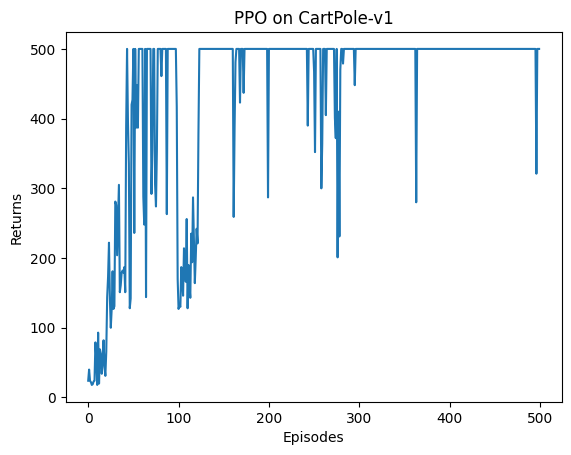

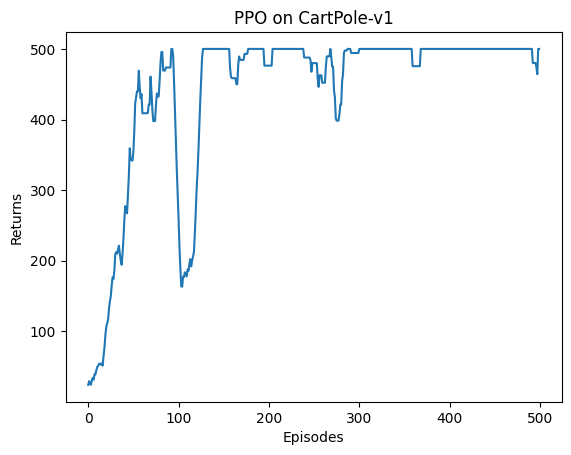

In [12]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f"PPO on {env_name}")
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f"PPO on {env_name}")
plt.show()